# We have used two classification algorithm (RandomForestClassifier and HistGradientBoostingClassifier) for prediction and  SHAP analysis.

In [1]:
!pip install shap

# ** Import libraries

In [2]:
import shap
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import HistGradientBoostingClassifier

#** Fetch data**

In [3]:
!git clone https://github.com/singhsumit1/AA_feature_selection.git

fatal: destination path 'AA_feature_selection' already exists and is not an empty directory.


# Fetch https://www.genome.jp/ftp/db/community/aaindex/aaindex1

In [4]:
# Specify the path to your text file
file_path = "/content/AA_feature_selection/prop_amino_details" #'/content/drive/MyDrive/prop_amino_details'

# Open the file and read it line by line
with open(file_path, 'r') as file:
    file_content = file.read()

# Now, file_content contains the entire content of the file as a string
print(file_content)

H ANDN920101
D alpha-CH chemical shifts (Andersen et al., 1992)
R PMID:1575719
A Andersen, N.H., Cao, B. and Chen, C.
T Peptide/protein structure analysis using the chemical shift index method: 
  upfield alpha-CH values reveal dynamic helices and aL sites
J Biochem. and Biophys. Res. Comm. 184, 1008-1014 (1992)
C BUNA790102    0.949
I    A/L     R/K     N/M     D/F     C/P     Q/S     E/T     G/W     H/Y     I/V
    4.35    4.38    4.75    4.76    4.65    4.37    4.29    3.97    4.63    3.95
    4.17    4.36    4.52    4.66    4.44    4.50    4.35    4.70    4.60    3.95
//
H ARGP820101
D Hydrophobicity index (Argos et al., 1982)
R PMID:7151796
A Argos, P., Rao, J.K.M. and Hargrave, P.A.
T Structural prediction of membrane-bound proteins
J Eur. J. Biochem. 128, 565-575 (1982)
C JOND750101    1.000  SIMZ760101    0.967  GOLD730101    0.936
  TAKK010101    0.906  MEEJ810101    0.891  ROSM880104    0.872
  CIDH920105    0.867  LEVM760106    0.865  CIDH920102    0.862
  MEEJ800102    0.85

#* Fetch list of properties https://www.genome.jp/aaindex/AAindex/list_of_indices

In [5]:
# Specify the path to your text file
file_path = '/content/AA_feature_selection/list_amino_prop.txt'
list_prop=[]
# Open the file and read it line by line
with open(file_path, 'r') as file:
    for line in file:
        # Process each line as needed
        print(line.strip())  # Print the stripped version of each line (without leading/trailing whitespaces)
        list_prop.append(line.strip().split()[0])




ANDN920101 alpha-CH chemical shifts (Andersen et al., 1992)
ARGP820101 Hydrophobicity index (Argos et al., 1982)
ARGP820102 Signal sequence helical potential (Argos et al., 1982)
ARGP820103 Membrane-buried preference parameters (Argos et al., 1982)
BEGF750101 Conformational parameter of inner helix (Beghin-Dirkx, 1975)
BEGF750102 Conformational parameter of beta-structure (Beghin-Dirkx, 1975)
BEGF750103 Conformational parameter of beta-turn (Beghin-Dirkx, 1975)
BHAR880101 Average flexibility indices (Bhaskaran-Ponnuswamy, 1988)
BIGC670101 Residue volume (Bigelow, 1967)
BIOV880101 Information value for accessibility; average fraction 35% (Biou et al., 1988)
BIOV880102 Information value for accessibility; average fraction 23% (Biou et al., 1988)
BROC820101 Retention coefficient in TFA (Browne et al., 1982)
BROC820102 Retention coefficient in HFBA (Browne et al., 1982)
BULH740101 Transfer free energy to surface (Bull-Breese, 1974)
BULH740102 Apparent partial specific volume (Bull-Breese, 

# Read https://www.genome.jp/ftp/db/community/aaindex/aaindex1

In [6]:
NA_numbers=0
def extract_properties(data):
    global NA_numbers
    properties = {}
    lines = data.split('\n')

    property_code = None
    amino_acids = None
    amino_values = None
    previous_line="Z"
    previous_line2p="Z"
    for line in lines:
        if line.startswith('H '):  # Line starting with 'H ' indicates a new property
            if property_code is not None and amino_acids is not None:
                properties[property_code] = dict(zip(amino_acids, amino_values))

            property_code = line.split()[1]  # Extract the property code
            property_values = []
            amino_acids = []
            amino_values = []
        elif line.startswith('I '):  # Line starting with 'I ' contains amino acid values
            amino_name = [str1.strip().split("/")[0] for str1 in line.split()[1:]]+ [str1.strip().split("/")[1] for str1 in line.split()[1:]]
            print(amino_name)
            amino_acids.extend(amino_name)  # Extract amino acids


        elif previous_line.startswith('I ') or previous_line2p.startswith('I '):  #
            value_list= line.strip().split()
            temp =[]
            for k in value_list:
              try:
                temp.append(float(k))
              except:
                temp.append(0.0)
                NA_numbers+=1
            amino_values.extend(temp)
            # for k in




        # elif line.strip() and amino_acids is not None:  # Non-empty line and we are processing amino acid values
        #     values = [float(value) if value.replace('.', '').replace('-', '').isdigit() else None for value in line.split()]  # Extract property values
        #     property_values.extend(values)

        previous_line2p=previous_line
        previous_line=line
    if property_code is not None and amino_acids is not None:
        properties[property_code] = dict(zip(amino_acids, amino_values))

    return properties

# Example data
example_data = """
H ANDN920101
D alpha-CH chemical shifts (Andersen et al., 1992)
R PMID:1575719
A Andersen, N.H., Cao, B. and Chen, C.
T Peptide/protein structure analysis using the chemical shift index method:
  upfield alpha-CH values reveal dynamic helices and aL sites
J Biochem. and Biophys. Res. Comm. 184, 1008-1014 (1992)
C BUNA790102    0.949
I    A/L     R/K     N/M     D/F     C/P     Q/S     E/T     G/W     H/Y     I/V
    4.35    4.38    4.75    4.76    4.65    4.37    4.29    3.97    4.63    3.95
    4.17    4.36    4.52    4.66    4.44    4.50    4.35    4.70    4.60    3.95
//
H ARGP820101
D Hydrophobicity index (Argos et al., 1982)
R PMID:7151796
A Argos, P., Rao, J.K.M. and Hargrave, P.A.
T Structural prediction of membrane-bound proteins
J Eur. J. Biochem. 128, 565-575 (1982)
C JOND750101    1.000  SIMZ760101    0.967  GOLD730101    0.936
  TAKK010101    0.906  MEEJ810101    0.891  ROSM880104    0.872
  CIDH920105    0.867  LEVM760106    0.865  CIDH920102    0.862
  MEEJ800102    0.855  MEEJ810102    0.853  ZHOH040101    0.841
  CIDH920103    0.827  PLIV810101    0.820  CIDH920104    0.819
  LEVM760107    0.806  NOZY710101    0.800  GUYH850103   -0.808
  PARJ860101   -0.835  WOLS870101   -0.838  BULH740101   -0.854
I    A/L     R/K     N/M     D/F     C/P     Q/S     E/T     G/W     H/Y     I/V
    0.61    0.60    0.06    0.46    1.07      0.    0.47    0.07    0.61    2.22
    1.53    1.15    1.18    2.02    1.95    0.05    0.05    2.65    1.88    1.32
//
H ARGP820102
D Signal sequence helical potential (Argos et al., 1982)
R PMID:7151796
A Argos, P., Rao, J.K.M. and Hargrave, P.A.
T Structural prediction of membrane-bound proteins
J Eur. J. Biochem. 128, 565-575 (1982)
C ARGP820103    0.961  KYTJ820101    0.803  JURD980101    0.802
I    A/L     R/K     N/M     D/F     C/P     Q/S     E/T     G/W     H/Y     I/V
    1.18    0.20    0.23    0.05    1.89    0.72    0.11    0.49    0.31    1.45
    3.23    0.06    2.67    1.96    0.76    0.97    0.84    0.77    0.39    1.08
//
"""

# Extract physicochemical properties from the example data
physicochemical_properties = extract_properties(file_content)

# Display the results
for property_code, values in physicochemical_properties.items():
    print(f"\n{property_code}:")
    for amino_acid, value in values.items():
        print(f"{amino_acid}: {value}")


Streaming output truncated to the last 5000 lines.
P: -7.7
S: -3.9
T: -2.6
W: 1.2
Y: -4.5
V: 1.4

ROBB760102:
A: 2.3
R: -5.2
N: 0.3
D: 7.4
C: 0.8
Q: -0.7
E: 10.3
G: -5.2
H: -2.8
I: -4.0
L: -2.1
K: -4.1
M: -3.5
F: -1.1
P: 8.1
S: -3.5
T: 2.3
W: -0.9
Y: -3.7
V: -4.4

ROBB760103:
A: 6.7
R: 0.3
N: -6.1
D: -3.1
C: -4.9
Q: 0.6
E: 2.2
G: -6.8
H: -1.0
I: 3.2
L: 5.5
K: 0.5
M: 7.2
F: 2.8
P: -22.8
S: -3.0
T: -4.0
W: 4.0
Y: -4.6
V: 2.5

ROBB760104:
A: 2.3
R: 1.4
N: -3.3
D: -4.4
C: 6.1
Q: 2.7
E: 2.5
G: -8.3
H: 5.9
I: -0.5
L: 0.1
K: 7.3
M: 3.5
F: 1.6
P: -24.4
S: -1.9
T: -3.7
W: -0.9
Y: -0.6
V: 2.3

ROBB760105:
A: -2.3
R: 0.4
N: -4.1
D: -4.4
C: 4.4
Q: 1.2
E: -5.0
G: -4.2
H: -2.5
I: 6.7
L: 2.3
K: -3.3
M: 2.3
F: 2.6
P: -1.8
S: -1.7
T: 1.3
W: -1.0
Y: 4.0
V: 6.8

ROBB760106:
A: -2.7
R: 0.4
N: -4.2
D: -4.4
C: 3.7
Q: 0.8
E: -8.1
G: -3.9
H: -3.0
I: 7.7
L: 3.7
K: -2.9
M: 3.7
F: 3.0
P: -6.6
S: -2.4
T: 1.7
W: 0.3
Y: 3.3
V: 7.1

ROBB760107:
A: 0.0
R: 1.1
N: -2.0
D: -2.6
C: 5.4
Q: 2.4
E: 3.1
G: -3.4
H: 0.8
I: -0.

In [7]:
NA_numbers

15

#** verifing the data length

In [8]:
for i in physicochemical_properties.keys():
  if len(physicochemical_properties[i])!= 20:
    print("not equal 20")
    print(i)

In [9]:
print(len(list_prop))
print(list_prop[:10])

566
['ANDN920101', 'ARGP820101', 'ARGP820102', 'ARGP820103', 'BEGF750101', 'BEGF750102', 'BEGF750103', 'BHAR880101', 'BIGC670101', 'BIOV880101']


#** Generate 566 d vector for the each Amino Acid like A.

In [10]:
Amino_name_char_2_566={}
Amino_name_chars=['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
for Amino_name_char in Amino_name_chars:
  prop_566=[]
  for prop in list_prop:
    prop_566.append(physicochemical_properties[prop][Amino_name_char])
  Amino_name_char_2_566[Amino_name_char]=prop_566

In [11]:
Amino_name_char_2_566.keys()

dict_keys(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'])

#** Read Positive data and and calculate max and min length. Positive data label denoted by 1

In [12]:
positive =[ "LRFILWWKR", "RWWIRIRWH", "RRRWWKLMM", "LRRWIRIRW", "RKFRWWVIR", "WKIVFWWRR", "RQRRVVIWW", "RRWRVIVKW", "RRYHWRIYI", "RKWKIKWYW", "YRLRVKWKW", "WKWRVRVTI", "RTKKWIVWI", "NWRKLYRRK", "YKFRWRIYI", "KRKKRFKWW", "KRWWKWIRW", "LLKKLLKK", "CLLKKLLKK", "LLKKLLKKC", "CLLKKLLKKC", "MLLKKLLKK", "LLKKLLKKM", "WKWLKKWIK", "RWRRKWWWW", "WRKFWKYLK", "KRWWKWWRR", "RRWWKWWWR", "KIWWWWRKR", "RLWWWWRRK", "KWKWWWRKI", "RIRRWKFRW", "RLKRWWKFL", "RWWRWRKWW", "KRWWWWRFR", "KRWWRKWWR", "RRWWRWVVW", "WFKMRWWGR", "KFKWWRMLI", "RIKRWWWWR", "RWRWWWRVY", "LKRRWKWWI", "RRRIKIRWY", "RLWWKIWLK", "KRRWRIWLV", "FFIYVWRRR", "IRMRIRVLL", "RWWRKIWKW", "MLLKKLLKKM", "ELAAIRHR", "RFGEPGGRE", "VEPIPY", "KKVVFKVKFK", "RKDVYRRRRRR", "RRRRRRRKDVY", "PLLKKLLKKP", "ILLKKLLKKI", "WLLKKLLKKW", "NVTSIHSLL", "TATELNNAL", "RTISEAGQAM", "AYQGVQQKW", "SEAYQGVQQ", "SEAYQGVQQK", "GVENVSW", "KMHATNH", "KTCENLADTY", "RIWVIWRR", "GLLKRIKTLL", "GLLKFIKKLL", "KLLKFIKKLL", "RLLKFIKKLL", "APKGVQGPNG", "KKVVVKVKFK", "KKVVFKFKFK", "KKLLFKLKFK", "KKVVPKVKFK", "ILRWKWRWWRWRR", "ILPWKWRWWKWRR", "FIKWKFRWWKWRK", "HQFRFRFRVRRK", "RRWKIVVIRWRR", "RLWRIVVIRVKR", "RLRRIVVIRVFR", "VRLRIRVRVIRK", "GRRRRSVQWCA", "GKKKKSVQWCA", "FKCRRWQWRMKKLG", "FKCKKWQWKMKKLG", "FRCRRWQWRMRRLG", "FWGLKGLKKFSKKL", "STLHLVLRLRGG", "GIGKFLKSKGKFGKA", "RKSAKKIGKRAKR", "EFAGAGFVRAGAL", "ELNNALQNLART", "SGSEAYQGVQQKWDA", "KMHATNHGGGS", "YPHHFKHRHIPI", "RRWRIVVIRVRR", "RLGRLVSLHTLG", "ATLHLVLRLRGG", "SALHLVLRLRGG", "STAHLVLRLRGG", "STLALVLRLRGG", "STLHAVLRLRGG", "STLHLALRLRGG", "STLHLVARLRGG", "STLHLVLALRGG", "STLHLVLRARGG", "STLHLVLRLAGG", "STLHLVLRLRAG", "STLHLVLRLRGA", "KTLTGKTITLE", "INWLKLGKMVIDAL", "YGRKKRRQRRR", "KRLFKKLLFSLRKY", "YKQCHKKGGKKGSG", "KWKLFKKIGAVLKVL", "ILSLRWRWKWWKK", "IFSAIAGLLSNLL", "KEFKRIVKRIKKFLRKL", "FWGLKGLKGPGKFSKKL", "SEFAYGSFVRTVSLPV", "TGMAALEQYLGSGHAVIVSI", "AVALGLASPADAAAGTMYGD", "SEFAYGSFVRTVSLPVGADE", "DEPDAERFEAAVEADHI", "KEFKRIVKRIKKFLRKLV", "QRSVSNAATRVCRTGRSRW", "YPHHFKHRHIPIGGGS", "EVEPSDTIENVKAKIQ", "RQIKIWFQNRRMKWKK", "RAGLQFPVGRVHRLLRK", "TKPKGTKPKGTKPKGTKPKG", "GYPWWDYRDLFGGHTFI", "GYPWWDYRDLFGGHTFISP", "LLIILRRRIRKQAHAHSK", "LPFFLLSLIPSAISAIKKI", "FFLLSLIPSAISAIKKI", "GNNRPVYIPQPRPPHPRI", "GNNRPVYIPRPRPPHPRL", "GNNKPVYIPRPRPPHPRLV", "AVAGEKLWLLPHLLKMLLTPTP", "FWGALAKGALKLIPSLFSSFSKKD", "FWGALAKGALKLIGSLFSSFSKKD", "VCDKMKILRGVCKKIMRTFLRR", "VCRTGRSRWRDVCRNFMRRYQSR", "DTHFPICIFCCGCCHRSKCGMCCKT", "KKLALLALKKWLLALKKLALLALKK", "KKLALLALKKWLPALKKLALLALKK", "KKLALALAKKWLALAKKLALALAKK", "KKALAHALKKWLPALKKLAHALAKK", "KKLALHALKKWLHALKKLAHLALKK", "VCEHIHLIRGLCHHLMHSYIKR", "VCDKMKILRGVCKKIMRSFLRR", "VCRTGRSRWRDVNRNFMRRYQSR", "WRSLGRTLLRLSHALKPLARRSGW", "AGYLLGKINLKALAALAKKIL", "GIGKFLHSAKKFGKAFVGEIMNS", "FWGFLGKLAMKAVPSLIGGNKSSSK", "FWGFLGKLAMKAVPSLIGGNKK", "KILRGVCKKIMRTFLRRISKDILTGKK", "FWGALAKGALKLIGPGSLFSSFSKKD", "KWKLFKKIGIGAVLKVLTTGLPALIS", "FVYGNGVTSILVQAQFLVNGQRRFFYTPDK", "KWKSFLKTFKSAKKTVLHTALKAISS", "KWKSFLKTFKSAKKTVLHTLLKAISS", "KWKSFLKTFKSLKKTVLHTLLKAISS", "KWKSFLKTFKSLKKTVLHTLLKLISS", "KWKSFLKTFKSLKKTKLHTLLKLISS", "VSNAATRVCRTGRSRWRDVCRNFMRRYQSR", "KWKSFIKKLTSAAKKVVTTAKPLISS", "GIGAVLKVLTTGLPALISWIKRKRQQ", "RRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFP", "AAARIRHEGVFLLIGNSCFSLPRNGPQLLLLAW", "PRVIETKVHGREVTGLARNVSEENVDRLAKRWIK", "ATYYGNGLYCNKQKHYTWVDWNKASREIGKITVNGWVQH", "TTKNYGNGVCNSVNWCQCGNVWASCNLATGCAAWLCKLA", "LLGDFFRKSKEKIGKEFKRIVQRIKDFLRN", "NEDTVTQAASRVCDKMKILRGVCKKIMRTFLRRISKD", "TQRSVSNAATRVCRTGRSRWRDVCRNFMRRYQSRVTQG", "LLGDFFRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES", "SVFPQQTTGQLAELQPQDRAGARASWMPMFQRRRRR", "ESTYQGHHTPPVQKGLRYGIILFITSEVFFFAGFF", "GLLRKGGEKIGEKLKKIGQKIKNFFQKLVPQPEQ", "GFGCPFNARRCHRHCRSIRRRAGYCAGRLRLTCTCVR", "GFGCPLNQGACHRHCRSIRRRGGYCSGIIKQTCY", "GWLKKIGKKIERVGQHTRDATIQGLGIAQQAANVAATARG", "ATCDLLSGTGINHSACAAHCLLRGNRGGYCNGKAVCVCRN", "RPPQFTRAQWFAIQHISLNPPRSTIAMRAINNYRWRSKNQNTFLR", "KPKGMTSSQWFKIQHMQPSPQASNSAMKNINKHTKRSKDLNTFLH", "KTYYGTNGVHCTKNSLWGKVRLKNMKYDQNTTYMGRLQDILLGWATGAFGKTH", "RWYYGNGVGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFTHNKACKSFPGSGWASG", "RPPQFTRAQWFAIQHISLMPPRCTIAMRAINNYRWRCKNQNTFLR", "ECYRKSDIVTCEPWQKFCYREVTFFPNHPVYLSGCASECTETNSKWCCTTDKCNRARGG", "VPAESEAAHLRVRRGFGCPLNQGACHNHCRSIRRRGGYCSGIIKQTCTCYRN", "RKDVY", "WYYQSGLSI", "YCNGKRVCVCR", "WGAQLNAMK", "QTYKWETFL", "PYNLRYRVL", "DAACAAHCLFR", "YLLDGLRAQ", "FLTSELPQW", "FIYAGSLSA", "AASAAIANR", "ALADLPVTV", "AMEDLVRAY", "AMASTEGNV", "ANNTRLWVY", "AMLGHAGDM", "KKLALALAKKWLPLAKKLALALAKK", "KYIFPGGLL", "KYIAADRKI", "ANTMAMMAR", "KLVANNTRL", "RMWELYLAY", "GWGSFFKKAAHVGKHVGKAALTHYL", "SARLAGIPY", "SIIIPTLNV", "VLAGSVDEL", "NGKRVCVCR", "VRLIVAVRIWRR", "VQRWLIVWRIRK", "VQLRIRVAVIRA", "LVYGDVIMR", "LVRAYHAMS", "NDAACAAHCLFRGRSGG", "KEFKRIVQRIKDFLRNLV", "IMYNYPAML", "IVLVRRWPK", "RSGGYCNGKRVCVCR", "LLDEGKQSL", "LPQWLSANR", "VTCDILSVEAKGVKL", "AAPEPVARR", "CNGKRVCVCR", "ELNNALQNL", "HAMSSTHEA", "IYAGSLSAL", "MLGHAGDMA", "QIMYNYPAM", "RKSKEKIGKEFKRIVQRIKDFLRNLVPRTES", "RRRRRR"]
positive_labels = [1]*len(positive)
positive_len = [len(w) for w in positive]
max_positive=max(positive_len)
print(len(positive))
print(min(positive_len))
max_positive


246
5


61

#**Convert positive data into vector of properties value

In [13]:
final_dataset_positive = []
for neg in positive:
  temp=[]
  for ele in neg:
    temp=temp+Amino_name_char_2_566[ele.upper()]
  final_dataset_positive.append(temp)

#** Read Negative data and and calculate max and min length. Negative data label denoted by 0

In [14]:
negative = ["SGSSGHGRQGTTHGQTGDTT" , "GLDDLLEPVLNSADNLVHGL" , "EKHCQTSGEKGYCHGTKCK" , "AAAGSCVWGAVNYTSDCAAE" , "RKLKKSVKKRAKKFFKKPRVI" , "TKLNSAACGAHCLALG" , "YGRDDRSDVCRQVQHNWLV" , "AVKNGLQKLRNQCQANNGQ" , "PLNQGACHNHCRSIRRR" , "CRWCCNCCKANKGCGFCC" , "QWSNFPPKCIRECAMVSS" , "GESCAMISFCFTEVIGCSCKNKVC" , "FLRTFKSPVRTVFHT" , "GRCNASAGPPYCCSSYCFQIA" , "LSFEAKGIAVNHSAC" , "IKSIASKVANTVQKLKRKAKNAV" , "KISGKAIKNLFIKGAKNVGKR" , "GCPGNQLKCNNHCKSISCRA" , "FKKILKYLAGPAKFLHSAK" , "IKEAAKTAGLMAMGFV" , "KVPVGAIKKGGKAIKTGLGVVG" , "IGAGKSAAQSVLKSLSCKIS" , "GSGCIGQTVVGGWLGGAI" , "IFTKIQGTYRGKAKC" , "KKAAHVAKHVAKAALTH" , "ITSCSMQNCGTGSCKKR" , "RRWVRRVRRVWRRVVRVVRRWV" , "YMCPVVSSFCKQHCARL" , "RWCVYSYVRVRGVLVRYRRC" , "SSIGSILGKFAKGGAQAFLQPK" , "ELEALKGSITNFVQTA" , "AKFLGKNLLKQGACYAACKASK" , "MTDAGISGAIAGAVAGCA" , "LLGDFFRKAKEKIGKEFKRIVQRIKDFLRNLVPR" , "GTVKDLLIGAGKSAAQSVLTANSCKL" , "NPGEYLAKYCFEPVILCCKPLSPTPTK" , "KKSCHTGLKKSAGWVIPIGTLVKNGI" , "ISRLAGLLRKGGEKIGEKLKKIGQKIKNFF" , "RRGKPSGGSRGSKMGSKDSKGGWRGRPGS" , "PRYDIGNVELSTAYRSFANQKAPGRLNQ" , "KTYFPHFDLSHGSAQVKGHGAKVAAALTKAVE" , "IFSKFAGRGLKNLFMKGAKKIGKEVGMDVLR" , "TLASHLPSDFTPAVHASLDKFLANVSTVLTSK" , "CVRGRCPSGMCCSQFGYCGKGPKYC" , "PKIRYSDVKKLEMKPKYPHCEEKMVI" , "VFDIIKGAGKQLIARAMGKIAEKVGLNKD" , "EAKGFAANHSLCAAHCLAIGRKGGACQNGVCVCR" , "SCSGTISPYGLRTCRATKTKPSHPTTKETHPQTLP" , "VLNKSEYMCPVVSSFCKQHCARLGKS" , "VIPCGESCVFIPCISTLLGCSCKNKVCYR" , "GEENVSYKPFVVSWKYGVAGCFYTHC" , "CSQQCKDREHFAYGGACHYQFPSVKCF" , "VKGLFHAGRMIHGLVNRRRHRHGMEELDLD" , "MDTAKNVAKNEAGNLLDNLKCKITKAC" , "IKVNGKPCKGSGEKKCSGGWSCKFNVCV" , "LIGSCVWGAVNYTSDCNGECKRRGYKGGHCGSFANVNC" , "ATKPTPSKPGYCRVMDELILCPDPPLSKDLCKNDSDCP" , "AGSCVWGAVNYTSDCNGECKRRGYKGGHCGSFANVNCWCRT" , "LKSLERRRLMITISTMLQFGLFLIALIGLVIKLIELSNKK" , "CENRCKCKVQLMGNCIKVPFKCFLWKQKRFMCECYGPIS" , "LKSLERRRLMITISTMLQFGLFLIALIGLVIKLIELSN" , "WFKGAKKGFQDYRYQKDMAKMNKRYGPNWQQRGGQEPPADAQ" , "CEDVNGQCQPRGNPCLRLRGACPRGSRCCMPTVAA" , "HIVKGLFHAGRMIHGLVNRRRHRHGMEELDLDQRAFEREKA" , "IPAAVAGTVLNVVEAGGWVTTIVSILTAVGSGGLSLLAAAGRESI" , "TVLQTVVHKVGKTQFGCPAYQGYCDDHCQDIEKKEGFCHGFKCKCGIPMG" , "SSVAATCQTPKIACKNGDKNCHQSHGAVSLTMCKLTSGKYPNCRYKE" , "VVREQGFSGHVHEQQAGHHHEAGHHEQAGHHEQSGQQVHGQGHGY" , "AKEGGKFG" , "LFKVFGYT" , "LLNTI" , "TVKNAAK" , "IKGAIH" , "FKRIRRAGKR" , "SAGCCS" , "QRGRFGRF" , "PPIVKDTLKKFFKGG" , "CSVNWG" , "DVIKK" , "RWVQRWK" , "SMFGAVLGVPA" , "KWKSFIK" , "EKLFSKIQN" , "VQKLKRK" , "KGLKF" , "RCPKSWKCKA" , "PRPLPFP" , "GKIAKVA" , "AKKCRCKIISG" , "LINKTVNKEA" , "SFLCL" , "FIKKLTSAAKKV" , "LFKKILKYLKFLHSA" , "KyPLKVKL" , "ALFKLASK" , "SKVFPAVF" , "NALVN" , "DIVRGI" , "IGKKFKRIVQRIK" , "ALKTAGKHVAG" , "AKTALLED" , "IIGGGAASGGAVY" , "VKPKTAKP" , "VWRRVVRVV" , "HLDDLPGAL" , "SDYPK" , "GSFFKN" , "GLGFVA" , "HQDCYEALHKCMA" , "VGRVASKVVPSLISM" , "PFPEVFGK" , "VSSGWKWNYKI" , "KSYKCLHKR" , "CKIDKSC" , "YGNGVHCTKSGCS" , "VRGVG" , "GKQLEDGRTLSDYN" , "PEEEAA" , "RRISKDI" , "RFHSVGSLIQRL" , "KFVGK" , "YFPHFDLS" , "TIGKLPKWI" , "PAVGVVGQASSIM" , "CTRGFC" , "LFKKI" , "HVGKTIHRLV" , "IVGMGKQVVCGLSG" , "TCCRAVIFRH" , "RVAANVLP" , "KAAHV" , "KVLRHLR" , "RRPRP" , "KYGKP" , "KKKKEVKMERK" , "WGAVNYT" , "RVSRTGRSRWRD" , "CRRRGCASR" , "LGALFKVA" , "LFRKRIESLLQ" , "NNHCKSISC" , "AKEAGKTGLEL" , "GSSIA" , "RLPRPRPRPLPFPR" , "IIQKLEDMVGPQ" , "NCHQSHG" , "KKKKKKKGIGKFLHS" , "QFLIKAQT" , "PVVIRTVVAGYNL" , "RKNNYSGPQFT" , "FAGLCF" , "GMCCSQFGYCGKG" , "KFKLK" , "VKGGLKIIGGTA" , "PQPRPPHPRL" , "LGKVVKGAS" , "PRRIYNN" , "LKCKITGC" , "PLGPAG" , "FLDQIIRDFRNFIYQ" , "CKEKEHLLSGRCRD" , "NRRRHRHGMEELDLD" , "IFRHERPE" , "KSGSGSKR" , "YYGNGVYCTKNKCT" , "WASSIGSI" , "VGMGKK" , "IRKLK" , "FYDLDLNVC" , "MQPSPQACNSAMKN" , "AIAKKKG" , "GSQLVYREWVGHSNV" , "ALGALFKVASKV" , "VPDAIMAG" , "PIKHQGLPQEVL" , "HFGRCPSHLIKGSCS" , "TPKIACKNGD" , "LIWKLLSK" , "CRSQEYRIGRCPN" , "SKVLGVG" , "LGLAL" , "ILKRILIK" , "LKNLGKVGLG" , "HDSGYEVHHQKLV" , "NLTKGGSKILTTGL" , "KVFKLASKV" , "GRGKQG" , "LFKKILKY" , "SLLSTASCKLAKT" , "IKIAGKK" , "DLSHGSAQVKGH" , "KLLPSVFKLFQ" , "LSFQEFLEQLRRF" , "RFWPLVPVAINT" , "LRESNCENVCK" , "SGTISPYGLRTCRAT" , "TFLHDSFQNVAAVCDLLSIVCKNRRHNCHQSSKPVNMTDCRLTSGKYPQCRYSAAA" , "PGLSQARHVNHSATEALRELREGATGQGTNGSQLLRHPGKRAPIIRRIPYYPEVES" , "SCLPKEEQIGKCSTRGRKCCR" , "GLLLDTVKGAAKNVAGILLNKLKCK" , "SCRKIIQKLEDMVGPQPNEDT" , "PWKLPATFRPVERPFSKP" , "GAVNYTSDCAAECKRRGYKGGHCGSF" , "CGESCVWIPCISTVIGCSCS" , "FWPVVIRTVVAGYNLYRA" , "STTARTARVPCAKKSNIYN" , "IGSAFKKAAHVGKHVGKAA" , "RCERRHRGDWQGKQRCLMEC" , "CNGPWSEKDMHCHNHCKSIKGYKGGYCAK" , "CVDTTSDFHTCQDKGGHCVSPKIRCLEEQLGLCPLKRWTCCK" , "PFSSVAATCQTPKIACKNGDKNCHQSHGAVSLTMCKLTSGKYPNCRYKEKR" , "DCTNDRKNCCPGHECKCY" , "RLPGTISREICAKKC" , "QKIISTIGKLPK" , "QKIKEFFQKLALEIE" , "GLVTRRRHGVEELQ" , "GFCWYVCVYRNGVRV" , "IGTGDGAAQS" , "KTYFPHFDLSHGS" , "AKKVLTTALKPISS" , "NVAVTLLDKL" , "GPAKFLHSA" , "SLQMGATAIKQVKKL" , "QQRQPGSTVHGRLETTH" , "VHASLDKF" , "ARCRKKRSC" , "AAVCGLAGY" , "ERVGQHTR" , "SGILGAGKKIVCGLSG" , "GGYCHGIFKQTCKCYK" , "KAKGELPAKG" , "TAFWGKVKVDEVGG" , "RIRWILRYWRWS" , "RRRRRRWWWRRRRR" , "LRWWRKWW" , "DLLSGTGANHSA" , "KHIVCGLTGCA" , "NHCKSIKGYKGGYCAK" , "NGFDCKSP" , "HGHICESFKSFCKDSG" , "YLTTGLPALI" , "EKCWVNKAENKQAI" , "AALRGCWTKSIPPKP" , "SGVAGKTAKD" , "PIIYCNRRSG" , "YRWWRRRW" ]
negative_labels=[0]*len(negative)
negative_len = [len(w) for w in negative]
max_negative=max(negative_len)
print(min(negative_len))
max_negative

5


56

#**Convert Negative data into vector of properties value

In [15]:
final_dataset_negative = []
for neg in negative:
  temp=[]
  for ele in neg:
    temp=temp+Amino_name_char_2_566[ele.upper()]
  final_dataset_negative.append(temp)

#**Merging positive da and Negative samples

In [16]:
final_dataset = final_dataset_positive + final_dataset_negative
final_labels =  positive_labels + negative_labels
print(len(final_dataset))
print(len(final_labels))

492
492


In [17]:
final_dataset[0]

[4.17,
 1.53,
 3.23,
 2.93,
 1.0,
 0.83,
 0.53,
 0.365,
 102.0,
 145.0,
 108.0,
 20.0,
 15.0,
 -2.46,
 0.842,
 8.423,
 4.385,
 6.5,
 0.42,
 0.4,
 0.98,
 0.186,
 1.07,
 0.69,
 -0.052,
 1.0,
 2.0,
 0.0,
 2.0,
 0.0,
 0.0,
 167.9,
 170.0,
 23.0,
 0.45,
 0.16,
 0.59,
 1.21,
 1.3,
 0.5,
 0.58,
 1.13,
 0.85,
 0.84,
 1.3,
 1.27,
 0.46,
 0.59,
 0.061,
 0.025,
 0.036,
 0.07,
 0.36,
 1.29,
 1.24,
 1.18,
 0.96,
 1.14,
 0.9,
 1.29,
 1.53,
 0.7,
 5.5,
 7.4,
 40.0,
 1.38,
 1.36,
 0.53,
 1.9,
 1.0,
 0.89,
 131.17,
 337.0,
 -11.0,
 9.6,
 2.36,
 1.7,
 2.59,
 0.92,
 4.0,
 4.92,
 1.52,
 4.45,
 10.1,
 -0.01,
 0.0,
 0.0,
 0.0,
 0.0,
 4.79,
 1.25,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.31,
 1.13,
 1.25,
 1.18,
 1.1,
 1.28,
 1.23,
 0.59,
 0.8,
 0.52,
 0.59,
 2.4,
 168.5,
 0.0,
 4.9,
 111.0,
 -1.18,
 0.8,
 -1.8,
 48.03,
 50.62,
 232.3,
 1.32,
 1.01,
 0.57,
 0.44,
 0.58,
 1.3,
 1.05,
 0.53,
 27.6,
 60.0,
 16.0,
 2.4,
 0.5,
 2.17,
 2.36,
 0.091,
 54.0,
 4.7,
 581.0,
 1.21,
 1.24,
 1.56,
 1.56,
 0.967,
 0.961,
 0.921,


# ** convert data into pandas dataframe. In the dataframe each row shows features coresponding to the each samples.

In [18]:
all_data_name=positive + negative
final_data_dict={}
for i in range(len(final_dataset)):
  final_data_dict[all_data_name[i]] = final_dataset[i]
#final_data_dict["labels"] = final_labels[i]


In [19]:
final_data__pd = pd.DataFrame.from_dict(final_data_dict, orient='index')
final_data__pd["labels"] = final_labels
final_data__pd



,0,1,2,3,4,5,6,7,8,9,...,34517,34518,34519,34520,34521,34522,34523,34524,34525,labels
LRFILWWKR,4.17,1.53,3.23,2.93,1.00,0.83,0.53,0.365,102.0,145.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
RWWIRIRWH,4.38,0.60,0.20,0.45,0.52,0.72,0.84,0.529,109.1,-70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
RRRWWKLMM,4.38,0.60,0.20,0.45,0.52,0.72,0.84,0.529,109.1,-70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
LRRWIRIRW,4.17,1.53,3.23,2.93,1.00,0.83,0.53,0.365,102.0,145.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
RKFRWWVIR,4.38,0.60,0.20,0.45,0.52,0.72,0.84,0.529,109.1,-70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EKCWVNKAENKQAI,4.29,0.47,0.11,0.23,0.73,0.55,0.53,0.497,84.7,-106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
AALRGCWTKSIPPKP,4.35,0.61,1.18,1.56,1.00,0.77,0.37,0.357,52.6,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
SGVAGKTAKD,4.50,0.05,0.97,0.81,0.35,0.55,0.84,0.507,54.9,-70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
PIIYCNRRSG,4.44,1.95,0.76,0.76,0.06,0.55,0.97,0.509,73.6,-20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# ** Fill the missing data with the mean of all availavle example values

In [20]:
df_filled = final_data__pd.apply(lambda col: col.fillna(col.mean()))
df_filled

,0,1,2,3,4,5,6,7,8,9,...,34517,34518,34519,34520,34521,34522,34523,34524,34525,labels
LRFILWWKR,4.17,1.53,3.23,2.93,1.00,0.83,0.53,0.365,102.0,145.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,1
RWWIRIRWH,4.38,0.60,0.20,0.45,0.52,0.72,0.84,0.529,109.1,-70.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,1
RRRWWKLMM,4.38,0.60,0.20,0.45,0.52,0.72,0.84,0.529,109.1,-70.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,1
LRRWIRIRW,4.17,1.53,3.23,2.93,1.00,0.83,0.53,0.365,102.0,145.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,1
RKFRWWVIR,4.38,0.60,0.20,0.45,0.52,0.72,0.84,0.529,109.1,-70.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EKCWVNKAENKQAI,4.29,0.47,0.11,0.23,0.73,0.55,0.53,0.497,84.7,-106.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,0
AALRGCWTKSIPPKP,4.35,0.61,1.18,1.56,1.00,0.77,0.37,0.357,52.6,16.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,0
SGVAGKTAKD,4.50,0.05,0.97,0.81,0.35,0.55,0.84,0.507,54.9,-70.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,0
PIIYCNRRSG,4.44,1.95,0.76,0.76,0.06,0.55,0.97,0.509,73.6,-20.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,0


# *Initialize SHAP for finding redunded features with Nan filled with mean dataframe.

In [21]:
shap.initjs()

customer = df_filled
customer.head()

,0,1,2,3,4,5,6,7,8,9,...,34517,34518,34519,34520,34521,34522,34523,34524,34525,labels
LRFILWWKR,4.17,1.53,3.23,2.93,1.00,0.83,0.53,0.365,102.0,145.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,1
RWWIRIRWH,4.38,0.60,0.20,0.45,0.52,0.72,0.84,0.529,109.1,-70.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,1
RRRWWKLMM,4.38,0.60,0.20,0.45,0.52,0.72,0.84,0.529,109.1,-70.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,1
LRRWIRIRW,4.17,1.53,3.23,2.93,1.00,0.83,0.53,0.365,102.0,145.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,1
RKFRWWVIR,4.38,0.60,0.20,0.45,0.52,0.72,0.84,0.529,109.1,-70.0,...,3.5,1.0,6.0,7.0,3.5,7.0,0.0,3.5,0.0,1


#* Devide the features vectors and the class vectors

In [22]:
X = customer.drop("labels", axis=1) # Independent variables
y = customer.labels # Dependent variable
y


LRFILWWKR          1
RWWIRIRWH          1
RRRWWKLMM          1
LRRWIRIRW          1
RKFRWWVIR          1
                  ..
EKCWVNKAENKQAI     0
AALRGCWTKSIPPKP    0
SGVAGKTAKD         0
PIIYCNRRSG         0
YRWWRRRW           0
Name: labels, Length: 492, dtype: int64

#** **RandomForestClassifier used for the training at the data and for predicting positive or negative class. With the help of model parameter SHAP will analysis the contribution of features for the predicrtion**

In [23]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Train a machine learning model

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = clf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74        72
           1       0.77      0.67      0.72        76

    accuracy                           0.73       148
   macro avg       0.73      0.73      0.73       148
weighted avg       0.73      0.73      0.73       148



In [24]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)

#** The summary plot shows the feature importance of each feature in the model. The results show that fetures which play major roles in determining the results.

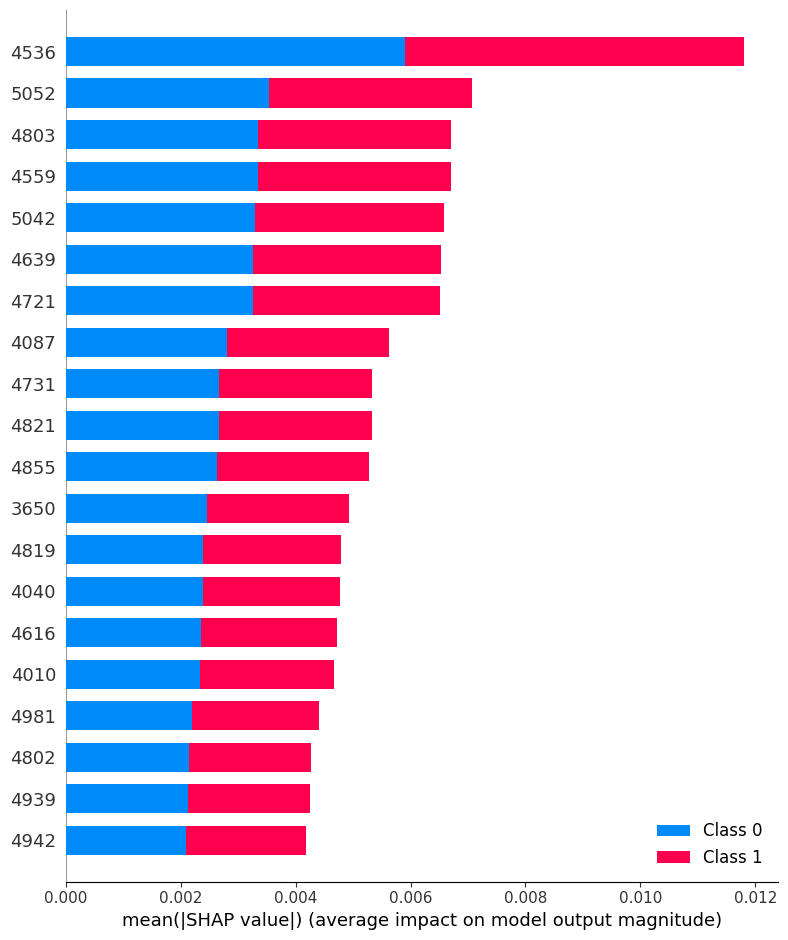

In [25]:
shap.summary_plot(shap_values, X_test)

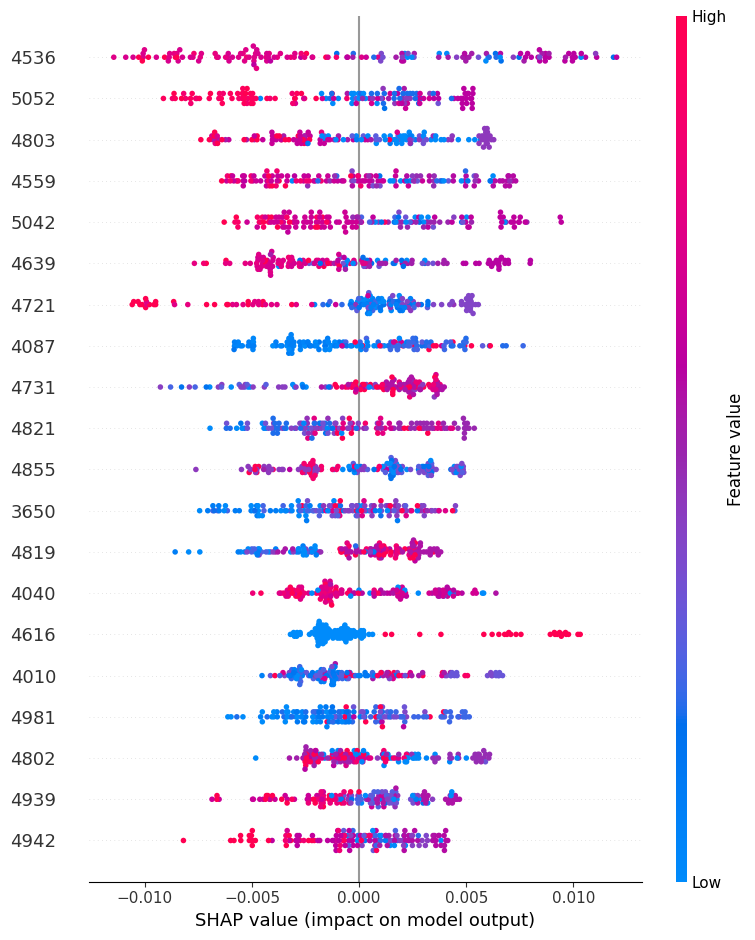

In [26]:
shap.summary_plot(shap_values[0], X_test)

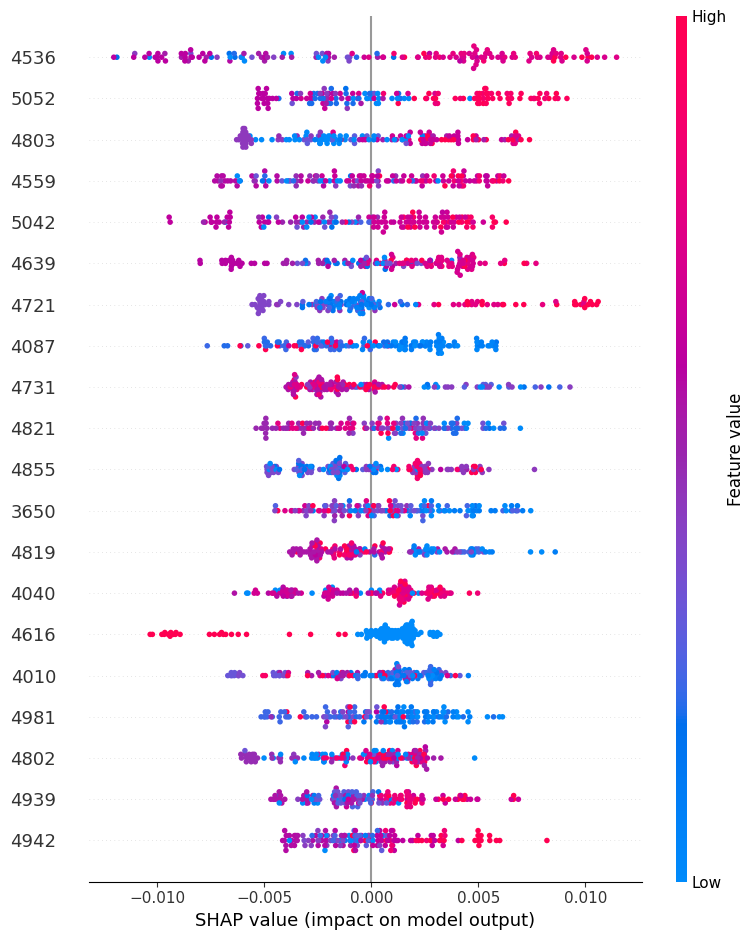

In [27]:
shap.summary_plot(shap_values[1], X_test)

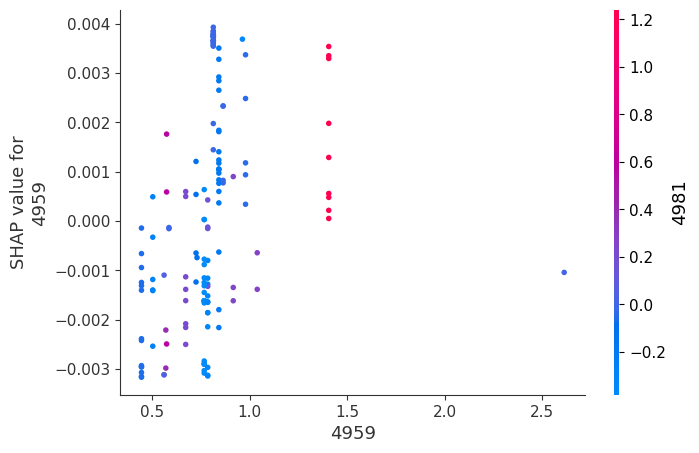

In [28]:
shap.dependence_plot(4959, shap_values[0], X_test,interaction_index=4981)

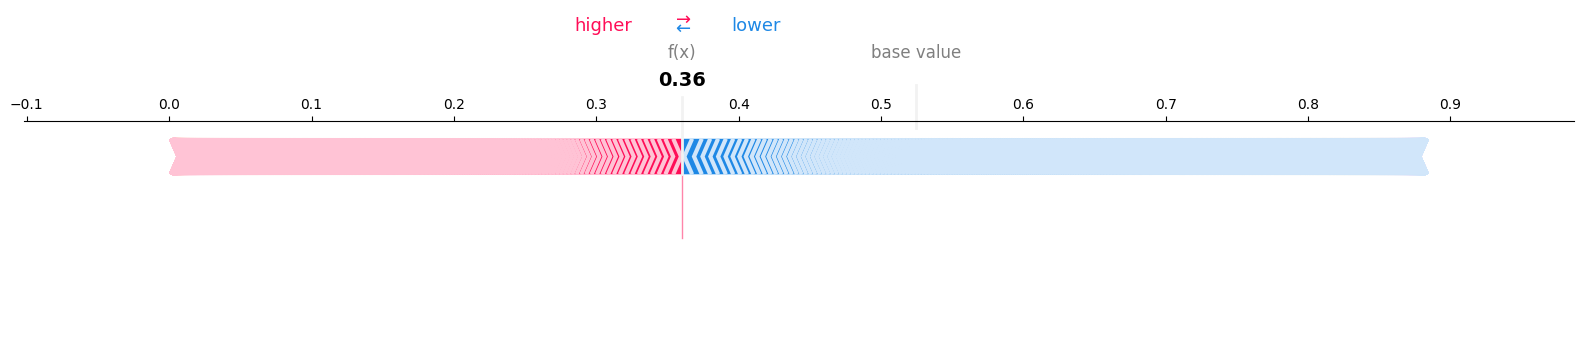

In [29]:
shap.plots.force(explainer.expected_value[1], shap_values[1][6, :], X_test.iloc[6, :],matplotlib = True)

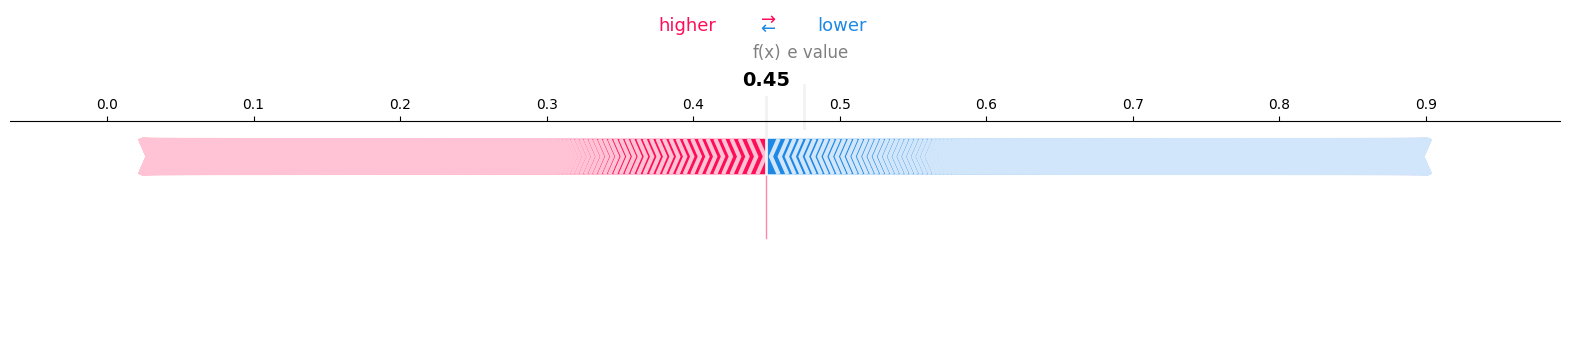

In [30]:
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0, :], matplotlib = True)

In [ ]:
# shap.decision_plot(explainer.expected_value[1], shap_values[1], X_test.columns)

In [ ]:
# shap.decision_plot(explainer.expected_value[0], shap_values[0], X_test.columns)

#** **HistGradientBoostingClassifier used for the training at the data and for predicting positive or negative class. With the help of model parameter SHAP will analysis the contribution of features for the predicrtion**


#*This time we are using dataset with Nan values

In [31]:
shap.initjs()

customer = final_data__pd
customer.head()

,0,1,2,3,4,5,6,7,8,9,...,34517,34518,34519,34520,34521,34522,34523,34524,34525,labels
LRFILWWKR,4.17,1.53,3.23,2.93,1.00,0.83,0.53,0.365,102.0,145.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
RWWIRIRWH,4.38,0.60,0.20,0.45,0.52,0.72,0.84,0.529,109.1,-70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
RRRWWKLMM,4.38,0.60,0.20,0.45,0.52,0.72,0.84,0.529,109.1,-70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
LRRWIRIRW,4.17,1.53,3.23,2.93,1.00,0.83,0.53,0.365,102.0,145.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
RKFRWWVIR,4.38,0.60,0.20,0.45,0.52,0.72,0.84,0.529,109.1,-70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [32]:


X = customer.drop("labels", axis=1) # Independent variables
y = customer.labels # Dependent variable
y


LRFILWWKR          1
RWWIRIRWH          1
RRRWWKLMM          1
LRRWIRIRW          1
RKFRWWVIR          1
                  ..
EKCWVNKAENKQAI     0
AALRGCWTKSIPPKP    0
SGVAGKTAKD         0
PIIYCNRRSG         0
YRWWRRRW           0
Name: labels, Length: 492, dtype: int64

In [33]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Train a machine learning model

clf = HistGradientBoostingClassifier()
clf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = clf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.68      0.79      0.73        71
           1       0.77      0.66      0.71        77

    accuracy                           0.72       148
   macro avg       0.73      0.73      0.72       148
weighted avg       0.73      0.72      0.72       148



In [34]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)

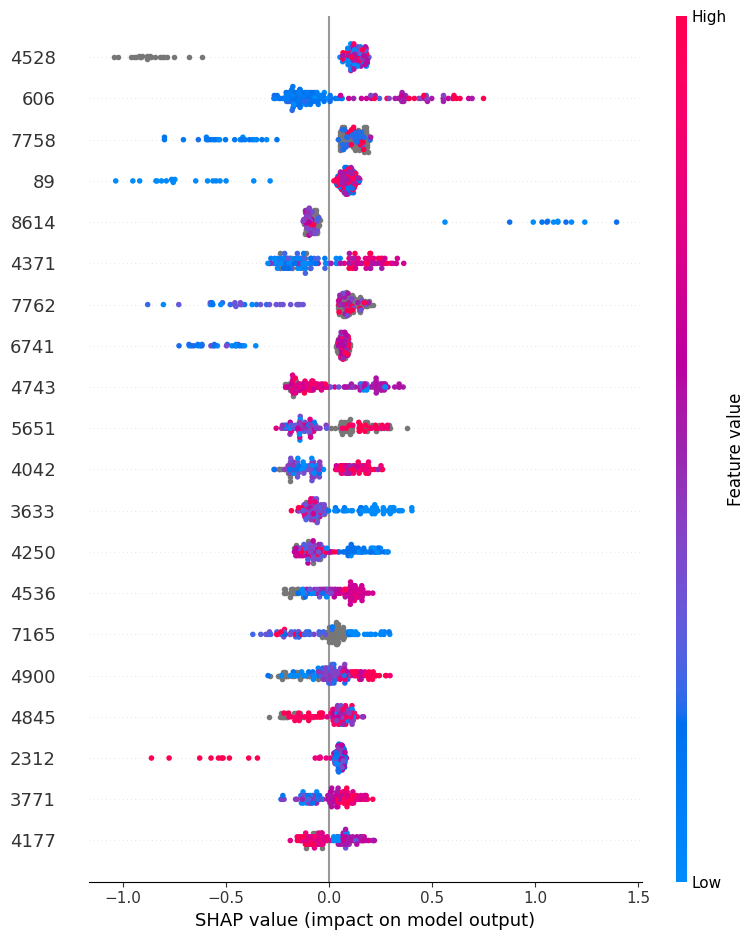

In [35]:
shap.summary_plot(shap_values, X_test)

In [ ]:
#https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability